# Imports

In [80]:
import glob
import cv2
import os

import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [81]:
print(os.listdir("../input/intel-mobileodt-cervical-cancer-screening"))

['additional_Type_2_v2', 'test_stg2.7z', 'fixed_labels_v2.csv', 'train', 'sample_submission.csv', 'test', 'additional_Type_1_v2', 'sample_submission_stg2.csv', 'test_stg2_7z_password.txt', 'additional_Type_3_v2', 'removed_files.csv', 'solution_stg1_release.csv']


# Data import

In [82]:
#getting the total number of images in the training set

base_dir = '../input/intel-mobileodt-cervical-cancer-screening'

train_dir = os.path.join(base_dir,'train', 'train')

type1_dir = os.path.join(base_dir,'Type_1')
type2_dir = os.path.join(base_dir,'Type_2')
type3_dir = os.path.join(base_dir,'Type_3')

type1_files = glob.glob(type1_dir+'/*.jpg')
type2_files = glob.glob(type2_dir+'/*.jpg')
type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(base_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(base_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(base_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')

type1_files = type1_files + added_type1_files
type2_files = type2_files + added_type2_files
type3_files = type3_files + added_type3_files


print('Number of images in a train set of type 1: ', len(type1_files))
print('Number of images in a train set of type 2: ', len(type2_files))
print('Number of images in a train set of type 3: ', len(type3_files))
print('Total number of images in a train set: ', sum([len(type1_files), len(type2_files), len(type3_files)]))

Number of images in a train set of type 1:  1191
Number of images in a train set of type 2:  3567
Number of images in a train set of type 3:  1976
Total number of images in a train set:  6734


In [83]:
# Building a dataframe mapping images and Cancer type

files_df = pd.DataFrame({
    'filename': type1_files + type2_files + type3_files,
    'label': ['Type_1'] * len(type1_files) + ['Type_2'] * len(type2_files) + ['Type_3'] * len(type3_files)
})

files_df

,filename,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
2,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
...,...,...
6729,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6730,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6731,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
6732,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


In [84]:
#Shuffle data

random_state = 42

files_df = files_df.sample(frac=1, random_state=random_state)
# files_df = files_df.sample(n=100, random_state=random_state)

files_df

,filename,label
381,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
4696,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
5577,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
2018,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
2185,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
...,...,...
4863,../input/intel-mobileodt-cervical-cancer-scree...,Type_3
1446,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
1188,../input/intel-mobileodt-cervical-cancer-scree...,Type_1
6471,../input/intel-mobileodt-cervical-cancer-scree...,Type_3


# Data exploration

In [85]:
files_df.describe()

,filename,label
count,100,100
unique,100,3
top,../input/intel-mobileodt-cervical-cancer-scree...,Type_2
freq,1,52


In [86]:
#Check for duplicates
len(files_df[files_df.duplicated()])

0

In [87]:
#Get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts())
type_count

,count
label,
Type_2,52
Type_3,34
Type_1,14


In [88]:
print(list(type_count.columns)[0])

count


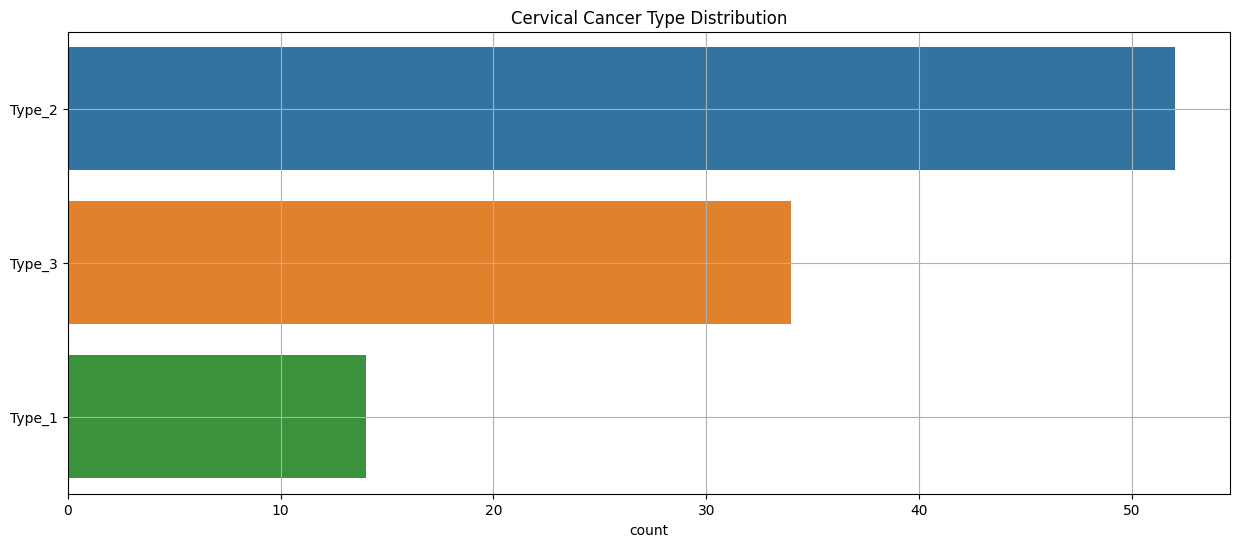

In [89]:
# Display barplot of type count

plt.figure(figsize = (15, 6))
sns.barplot(x= type_count[list(type_count.columns)[0]], y= type_count.index.to_list())
plt.title('Cervical Cancer Type Distribution')
plt.grid(True)
plt.show()

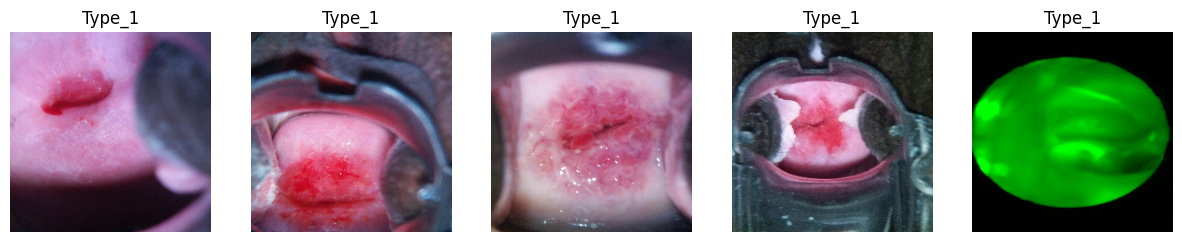

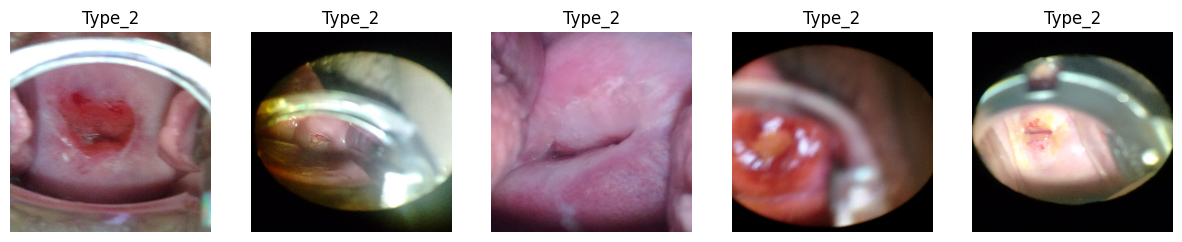

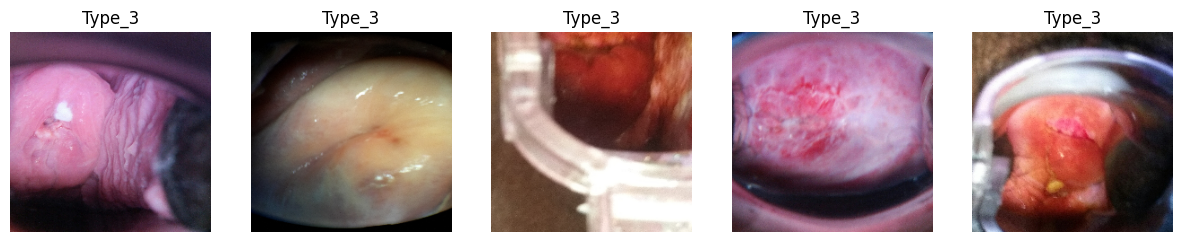

In [90]:
# Display sample images of types
for label in ('Type_1', 'Type_2', 'Type_3'):
    filepaths = files_df[files_df['label']==label]['filename'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data propocessing

In [91]:
# Split training,val and test set : 70:15:15

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, 
                                                                      random_state=random_state)

test_files, val_files, test_labels, val_labels = train_test_split(test_files,
                                                                  test_labels, 
                                                                  test_size=0.5, 
                                                                  random_state=random_state)


print('Number of images in train set: ', train_files.shape)
print('Number of images in validation set: ', val_files.shape)
print('Number of images in test set: ', test_files.shape, '\n')

print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

Number of images in train set:  (70,)
Number of images in validation set:  (15,)
Number of images in test set:  (15,) 

Train: Counter({'Type_2': 30, 'Type_3': 27, 'Type_1': 13}) 
Val: Counter({'Type_2': 12, 'Type_3': 2, 'Type_1': 1}) 
Test: Counter({'Type_2': 10, 'Type_3': 5})


In [92]:
def load_images(files, labels):
    features = []
    correct_labels = []
    bad_images = 0
    
    for i in range(len(files)):
        try:
            img = cv2.imread(files[i])
            resized_img = cv2.resize(img, (160, 160))
            
            features.append(np.array(resized_img))
            correct_labels.append(labels[i])
                   
        except Exception as e:
            bad_images+=1
            print('Encoutered bad image')
    print('Bad images ecountered:', bad_images)
    return np.array(features), np.array(correct_labels)

In [93]:
# Load training and evaluation data
train_features, train_labels = load_images(train_files, train_labels)
print('Train images loaded')

val_features, val_labels = load_images(val_files, val_labels)
print('Validation images loaded')

test_features, test_labels = load_images(test_files, test_labels)
print('test images loaded')

Bad images ecountered: 0
Train images loaded
Bad images ecountered: 0
Validation images loaded
Bad images ecountered: 0
test images loaded


In [94]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(val_features), len(val_labels), len(test_features), len(test_labels) 

(70, 70, 15, 15, 15, 15)

In [95]:
BATCH_SIZE = 32
NUM_CLASSES = 3
EPOCHS = 10
INPUT_SHAPE = (160, 160, 3)

In [96]:
# encode train+val sets text categories with labels
le = LabelEncoder()
le.fit(train_labels)

train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

train_labels_1hotenc = tf.keras.utils.to_categorical(train_labels_enc, num_classes=NUM_CLASSES)
val_labels_1hotenc = tf.keras.utils.to_categorical(val_labels_enc, num_classes=NUM_CLASSES)

print(train_labels[:6], train_labels_enc[:6])
print(train_labels[:6], train_labels_1hotenc[:6])

['Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_2' 'Type_2'] [2 1 1 1 1 1]
['Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_2' 'Type_2'] [[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [97]:

le = LabelEncoder()
le.fit(test_labels)

test_labels_enc = le.transform(test_labels)

test_labels_1hotenc = tf.keras.utils.to_categorical(test_labels_enc, num_classes=NUM_CLASSES)


print(test_labels[:6], test_labels_enc[:6])
print(test_labels[:6], test_labels_1hotenc[:6])

['Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2'] [1 0 0 0 1 0]
['Type_3' 'Type_2' 'Type_2' 'Type_2' 'Type_3' 'Type_2'] [[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


# Data augmentation

In [98]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

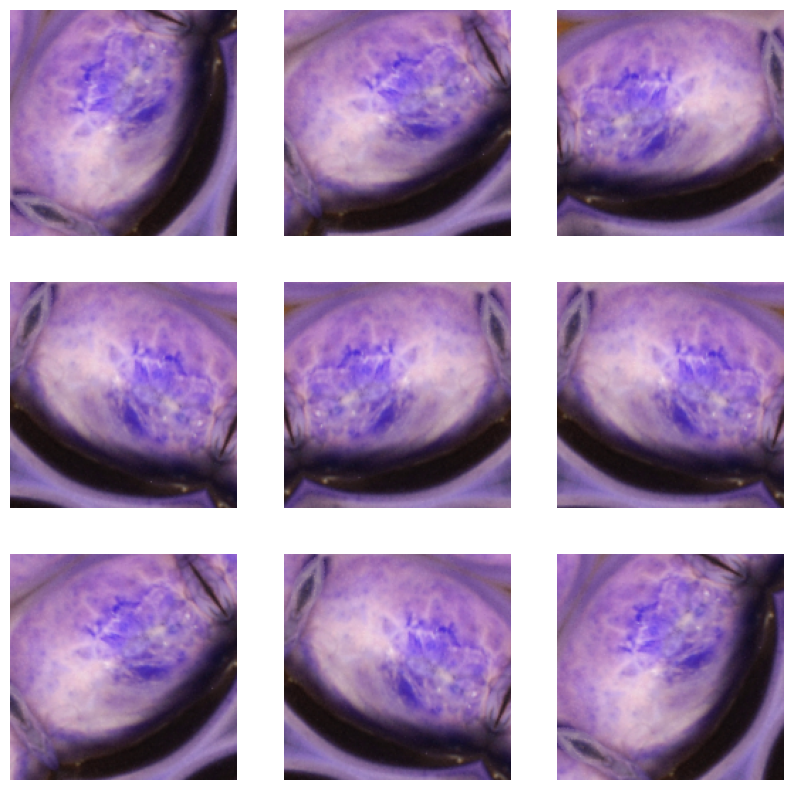

In [99]:
plt.figure(figsize=(10, 10))
first_image = train_features[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')
        

# Metrics

In [100]:
def get_accuracy_metrics(model, train_features=train_features, train_labels=train_labels_enc, test_features=test_features, test_labels=test_labels_enc, val_features=val_features, val_labels=val_labels_enc):    
    train_predicted = np.argmax(model.predict(train_features),axis=1)
    test_predicted = np.argmax(model.predict(test_features),axis=1)
    val_predicted = np.argmax(model.predict(val_features),axis=1)

    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(train_labels, train_predicted) *100), "%")
    
    print("Val accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(val_labels, val_predicted)*100), "%")
    
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(test_labels, test_predicted)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(test_labels, test_predicted)*100), "%")
    
    
    print("ROC AUC Score------------->")
    print("{0:.3f}".format(roc_auc_score(to_categorical(test_labels, num_classes = 3), test_predicted.reshape(-1, 1), multi_class='ovr')*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(test_labels, test_predicted, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(test_labels, test_predicted)
    cf_matrix_val = confusion_matrix(val_labels, val_predicted)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

# General Model Fit

In [101]:
def learning_performance_chart(title, history):
    #plots a chart showing the change in accuracy and loss function over epochs
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1,max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, max_epoch, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(1, max_epoch, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

    

In [102]:
def fit_model(model_name, base_model, train_features, train_labels, validate_it,training = False, epochs = EPOCHS, batch_size= BATCH_SIZE):
    
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    
    x = data_augmentation(inputs)
    x = base_model(x, training=training)
    
    if not model_name.startswith('CNN'):
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    
    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    model.compile(loss='categorical_crossentropy', optimizer ='adam', metrics=['accuracy'])
    
    print("Model Summary.")
    
    print(model.summary())
    
    history = model.fit(x=train_features,y=train_labels ,validation_data=validate_it, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[es])

    learning_performance_chart(title="{} learning performance.".format(model_name), history=history)
    
    return model

# CNN2

Model Summary.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_9 (Sequential)   (None, 3276800)           75916     
                                                                 
 dropout_15 (Dropout)        (None, 3276800)           0         
                                                                 
 dense_8 (Dense)             (None, 3)                 9830403   
                                                                 
Total params: 9,906,319
Trainable params: 9,906,185
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [===========

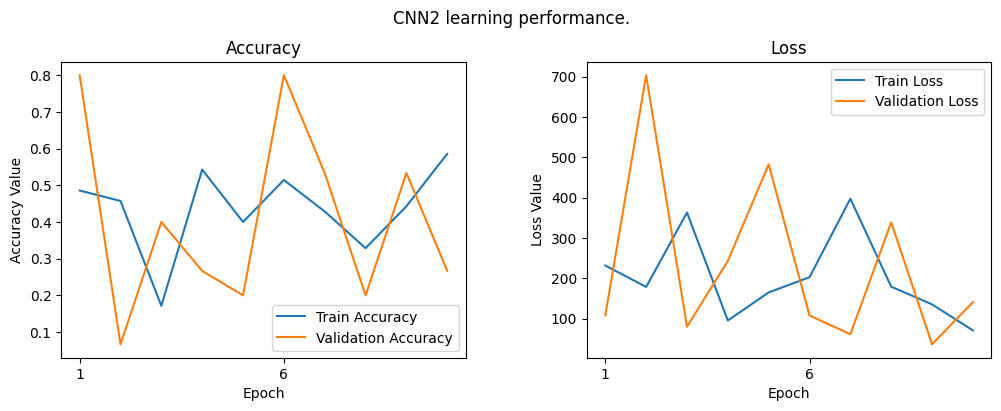

In [103]:
model = tf.keras.Sequential([
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
 tf.keras.layers.BatchNormalization(),
 tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
 tf.keras.layers.Flatten(),
])

cnn2 = fit_model("CNN2", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)


CNN2 performance on the test set:
1/1 [==============================] - 0s 169ms/step
Train accuracy Score------------>
41.429 %
Val accuracy Score--------->
26.667 %
Test accuracy Score--------->
53.333 %
F1 Score--------------->
51.852 %
Cohen Kappa Score------------->
-10.526 %
ROC AUC Score------------->
55.000 %
Recall-------------->
53.333 %
Precision-------------->
50.758 %


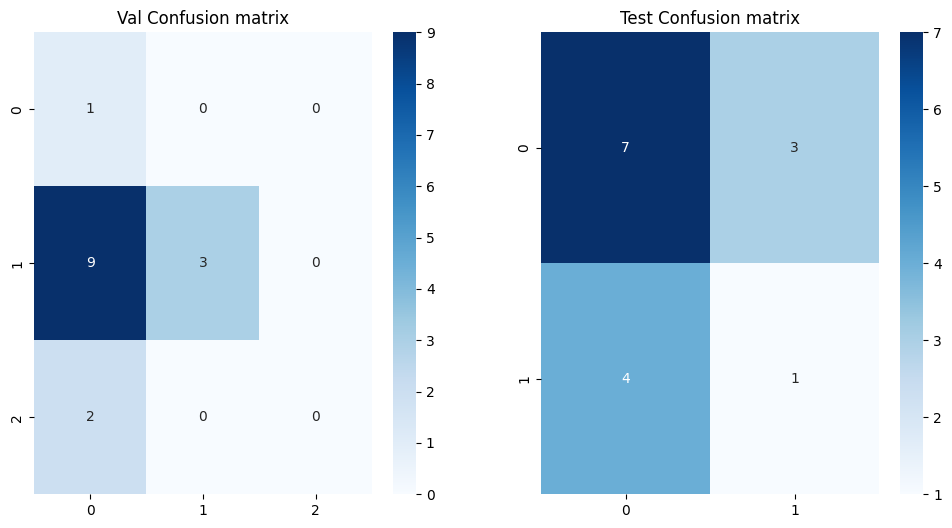

In [104]:
print('CNN2 performance on the test set:')
get_accuracy_metrics(cnn2)

# CNN3

Model Summary.
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_10 (Sequential)  (None, 819200)            223500    
                                                                 
 dropout_17 (Dropout)        (None, 819200)            0         
                                                                 
 dense_9 (Dense)             (None, 3)                 2457603   
                                                                 
Total params: 2,681,103
Trainable params: 2,680,969
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [===========

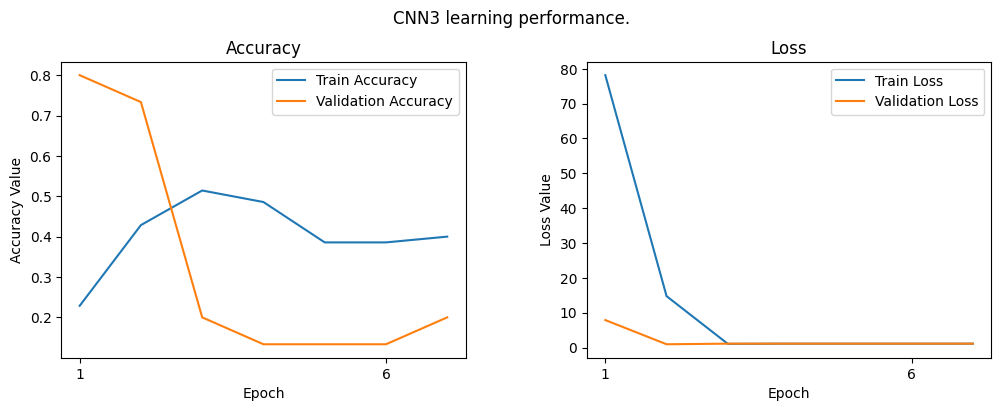

In [105]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
    ])

cnn3 = fit_model("CNN3", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

CNN3 performance on the test set:
1/1 [==============================] - 0s 260ms/step
Train accuracy Score------------>
37.143 %
Val accuracy Score--------->
13.333 %
Test accuracy Score--------->
0.000 %
F1 Score--------------->
0.000 %
Cohen Kappa Score------------->
0.000 %
ROC AUC Score------------->
50.000 %
Recall-------------->
0.000 %
Precision-------------->
0.000 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


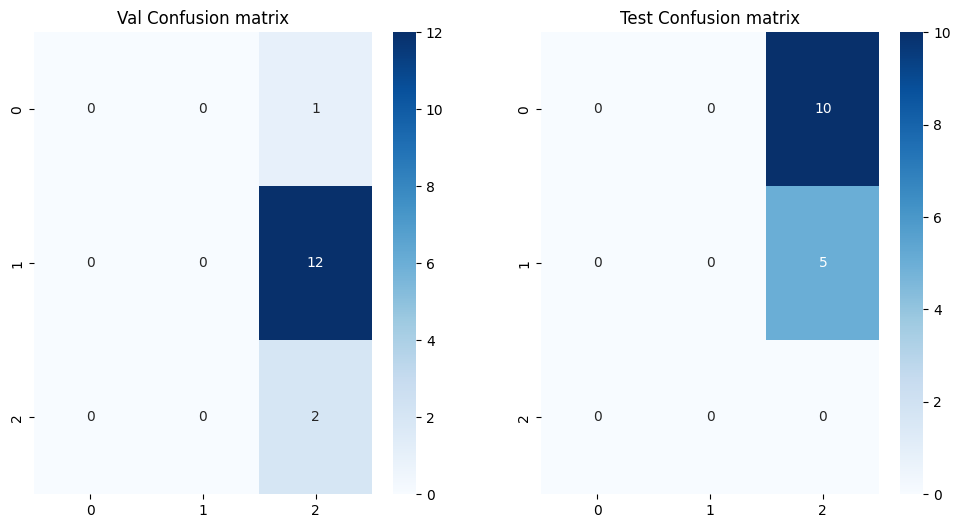

In [106]:
print('CNN3 performance on the test set:')
get_accuracy_metrics(cnn3)

# CNN4

Model Summary.
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_11 (Sequential)  (None, 102400)            297292    
                                                                 
 dropout_20 (Dropout)        (None, 102400)            0         
                                                                 
 dense_10 (Dense)            (None, 3)                 307203    
                                                                 
Total params: 604,495
Trainable params: 604,361
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [==============

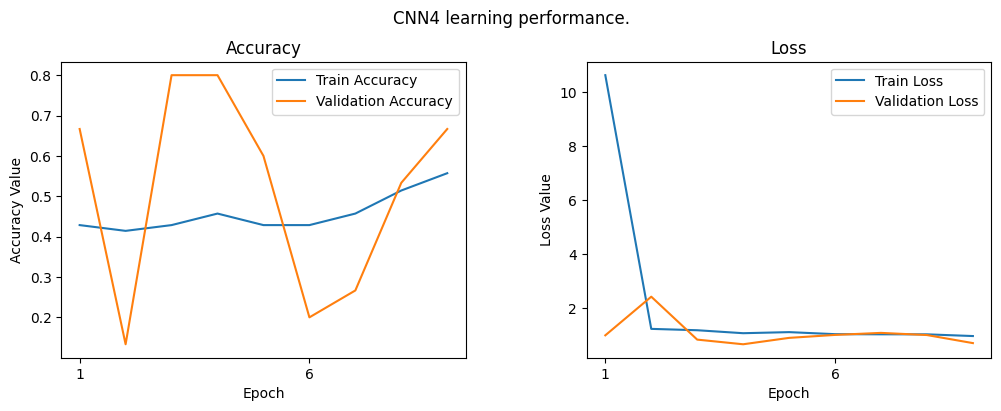

In [107]:
model = tf.keras.Sequential([
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.BatchNormalization(),
tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.MaxPooling2D(),
tf.keras.layers.Dropout(0.2),
tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
tf.keras.layers.Flatten(),
])

cnn4 = fit_model("CNN4", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)


CNN4 performance on the test set:
1/1 [==============================] - 0s 273ms/step
Train accuracy Score------------>
47.143 %
Val accuracy Score--------->
66.667 %
Test accuracy Score--------->
33.333 %
F1 Score--------------->
18.519 %
Cohen Kappa Score------------->
6.250 %
ROC AUC Score------------->
60.000 %
Recall-------------->
33.333 %
Precision-------------->
12.821 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


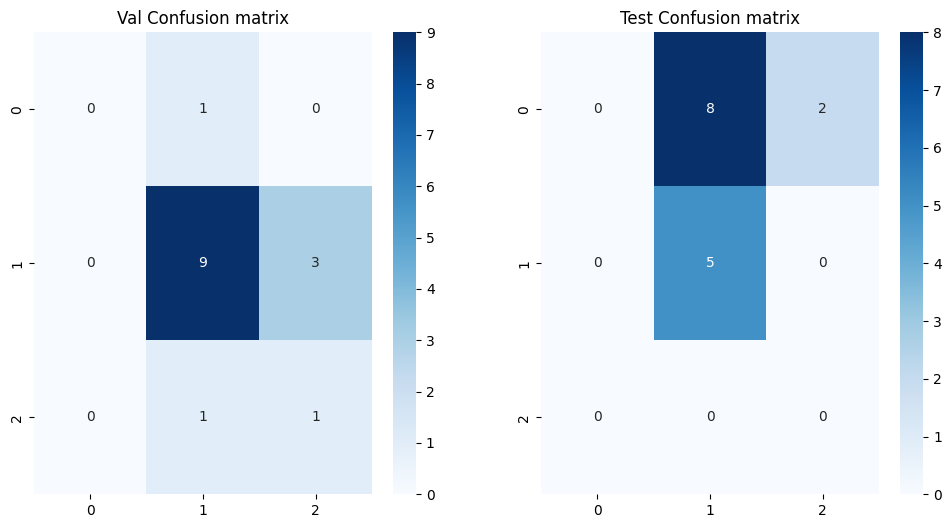

In [108]:
print('CNN4 performance on the test set:')
get_accuracy_metrics(cnn4)

# CNN5

Model Summary.
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_12 (Sequential)  (None, 12800)             315756    
                                                                 
 dropout_24 (Dropout)        (None, 12800)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                 38403     
                                                                 
Total params: 354,159
Trainable params: 354,025
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [==============

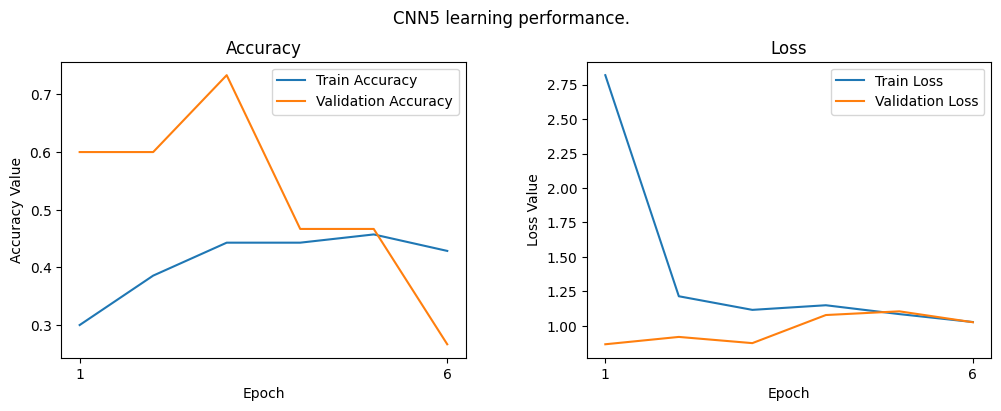

In [109]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(
        3, 3), padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
])


cnn5 = fit_model("CNN5", model, train_features, train_labels_1hotenc,
                       (val_features, val_labels_1hotenc), training=True)


CNN5 performance on the test set:
1/1 [==============================] - 0s 277ms/step
Train accuracy Score------------>
52.857 %
Val accuracy Score--------->
33.333 %
Test accuracy Score--------->
6.667 %
F1 Score--------------->
9.524 %
Cohen Kappa Score------------->
2.326 %
ROC AUC Score------------->
55.000 %
Recall-------------->
6.667 %
Precision-------------->
16.667 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


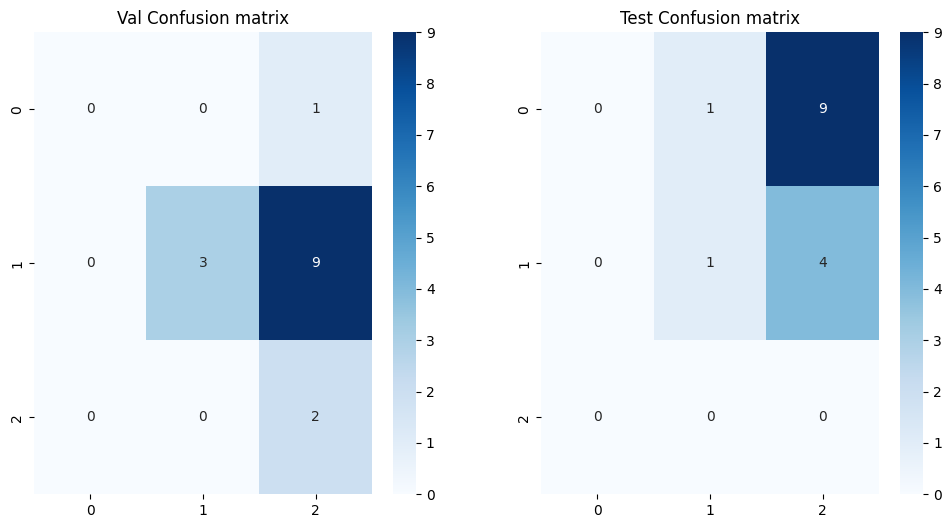

In [110]:
print('CNN5 performance on the test set:')
get_accuracy_metrics(cnn5)

# CNN6

Model Summary.
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 12800)             325004    
                                                                 
 dropout_28 (Dropout)        (None, 12800)             0         
                                                                 
 dense_12 (Dense)            (None, 3)                 38403     
                                                                 
Total params: 363,407
Trainable params: 363,273
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [==============

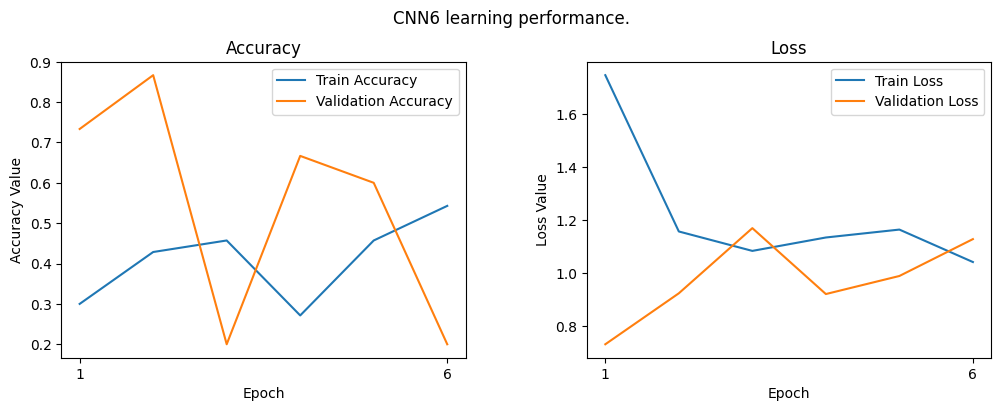

In [111]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn6 = fit_model("CNN6", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

CNN6 performance on the test set:
1/1 [==============================] - 0s 264ms/step
Train accuracy Score------------>
45.714 %
Val accuracy Score--------->
26.667 %
Test accuracy Score--------->
0.000 %
F1 Score--------------->
0.000 %
Cohen Kappa Score------------->
-2.273 %
ROC AUC Score------------->
45.000 %
Recall-------------->
0.000 %
Precision-------------->
0.000 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


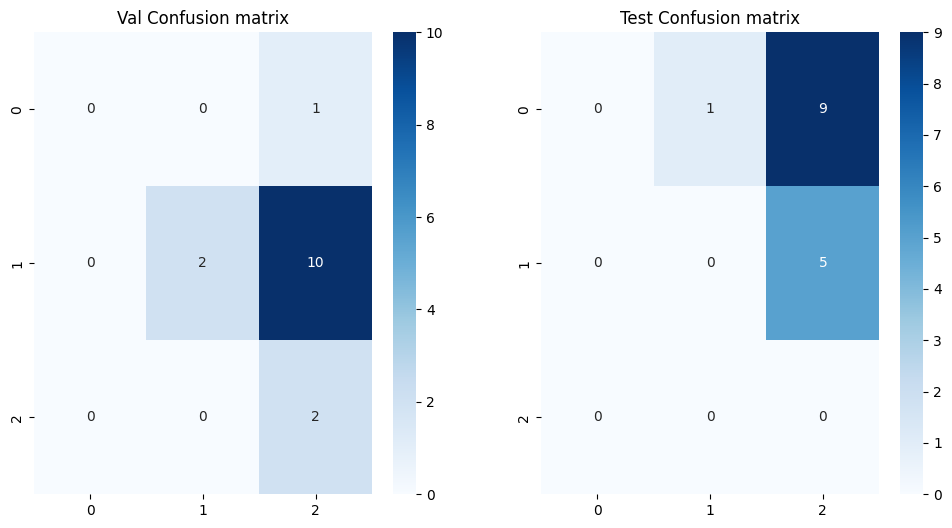

In [112]:
print('CNN6 performance on the test set:')
get_accuracy_metrics(cnn6)

# CNN7

Model Summary.
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_14 (Sequential)  (None, 1600)              329628    
                                                                 
 dropout_32 (Dropout)        (None, 1600)              0         
                                                                 
 dense_13 (Dense)            (None, 3)                 4803      
                                                                 
Total params: 334,431
Trainable params: 334,297
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [==============

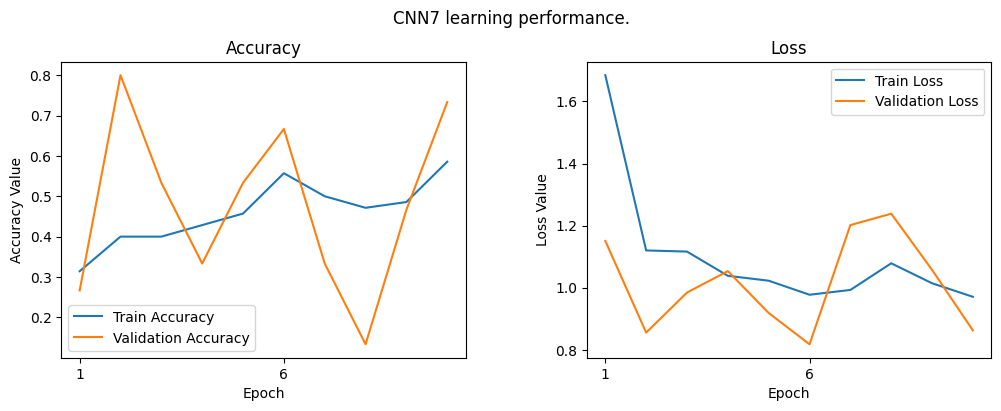

In [113]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn7 = fit_model("CNN7", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)

CNN7 performance on the test set:
1/1 [==============================] - 0s 272ms/step
Train accuracy Score------------>
52.857 %
Val accuracy Score--------->
66.667 %
Test accuracy Score--------->
13.333 %
F1 Score--------------->
8.889 %
Cohen Kappa Score------------->
-11.429 %
ROC AUC Score------------->
30.000 %
Recall-------------->
13.333 %
Precision-------------->
6.667 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


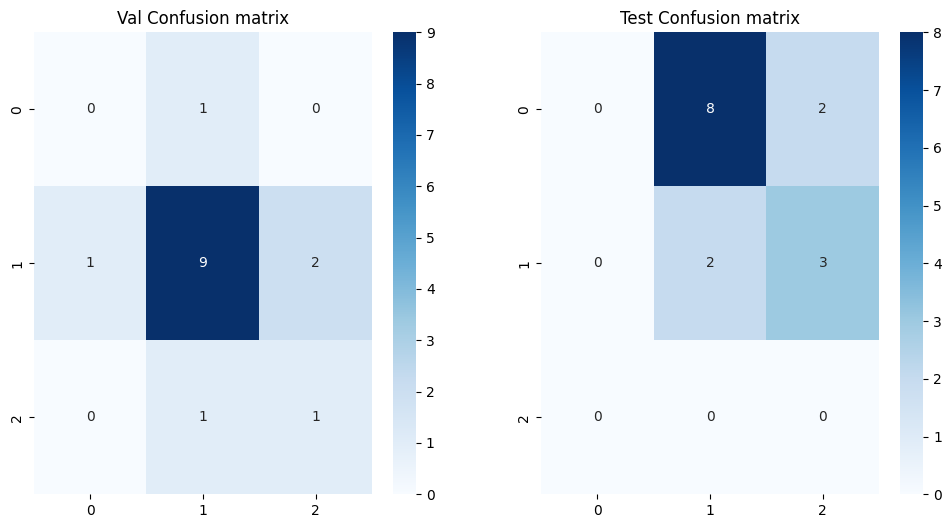

In [114]:
print('CNN7 performance on the test set:')
get_accuracy_metrics(cnn7)

# CNN8

Model Summary.
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 sequential_15 (Sequential)  (None, 1600)              331948    
                                                                 
 dropout_36 (Dropout)        (None, 1600)              0         
                                                                 
 dense_14 (Dense)            (None, 3)                 4803      
                                                                 
Total params: 336,751
Trainable params: 336,617
Non-trainable params: 134
_________________________________________________________________
None
Epoch 1/10
3/3 [==============

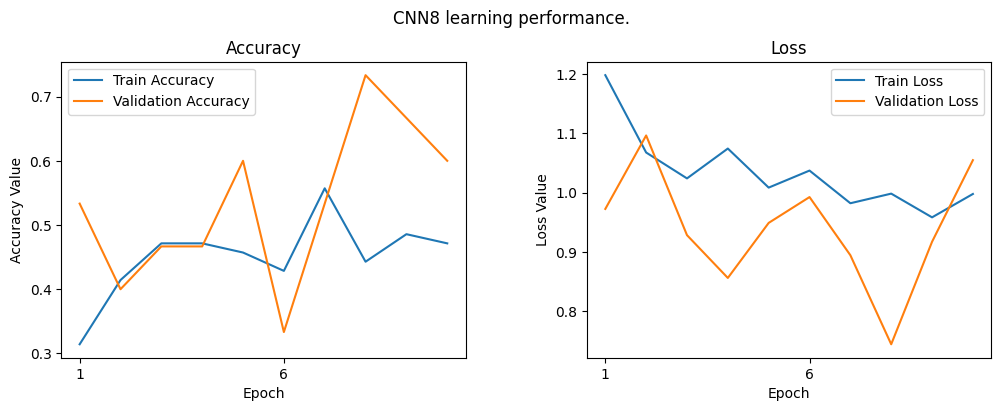

In [115]:
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation='relu'),
    tf.keras.layers.Flatten(),
])

cnn8 = fit_model("CNN8", model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc), training=True)



CNN8 performance on the test set:
1/1 [==============================] - 0s 267ms/step
Train accuracy Score------------>
61.429 %
Val accuracy Score--------->
40.000 %
Test accuracy Score--------->
13.333 %
F1 Score--------------->
13.333 %
Cohen Kappa Score------------->
2.500 %
ROC AUC Score------------->
55.000 %
Recall-------------->
13.333 %
Precision-------------->
13.333 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


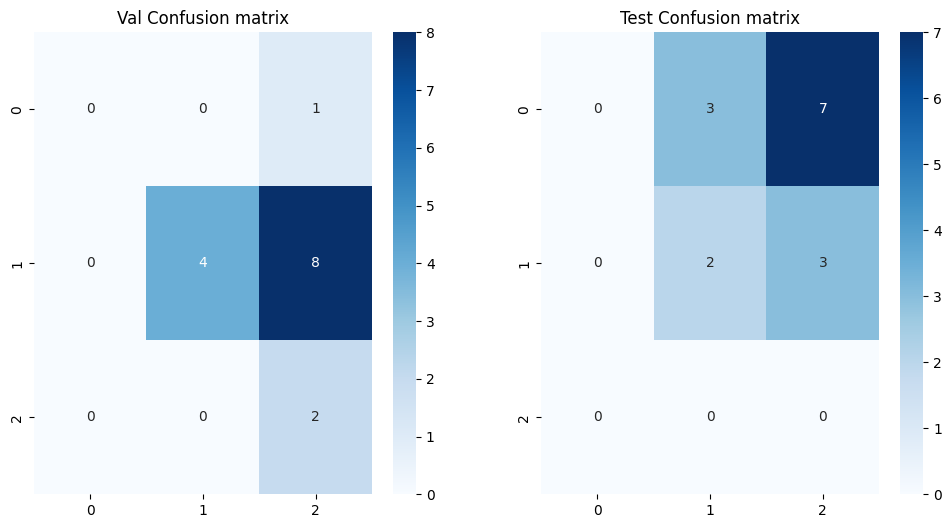

In [116]:
print('CNN8 performance on the test set:')
get_accuracy_metrics(cnn8)

# ResNet 50

94765736/94765736 [==============================] - 11s 0us/step
Model Summary.
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_37 (Dropout)        (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 3)     

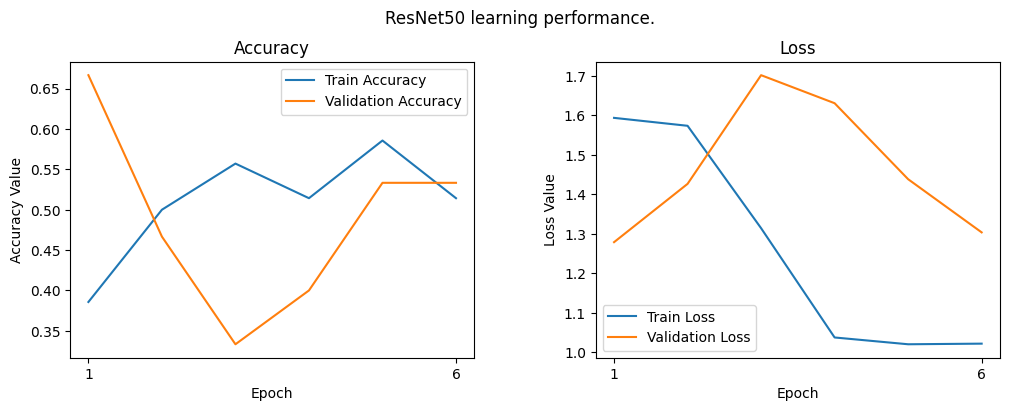

In [117]:
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    classes=NUM_CLASSES,
)

base_model.trainable = False

resnet50 = fit_model("ResNet50", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


ResNet50 performance on the test set:
1/1 [==============================] - 0s 178ms/step
Train accuracy Score------------>
57.143 %
Val accuracy Score--------->
53.333 %
Test accuracy Score--------->
33.333 %
F1 Score--------------->
40.000 %
Cohen Kappa Score------------->
-7.143 %
ROC AUC Score------------->
44.000 %
Recall-------------->
33.333 %
Precision-------------->
51.111 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


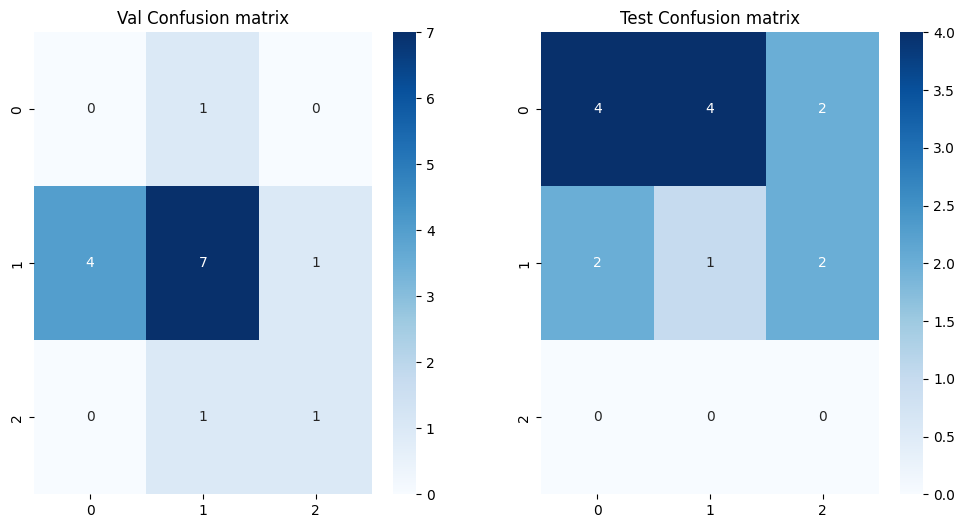

In [118]:
print('ResNet50 performance on the test set:')
get_accuracy_metrics(resnet50)

# VGG16

In [119]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

58889256/58889256 [==============================] - 7s 0us/step


Model Summary.
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 3)                 1539      
                                           

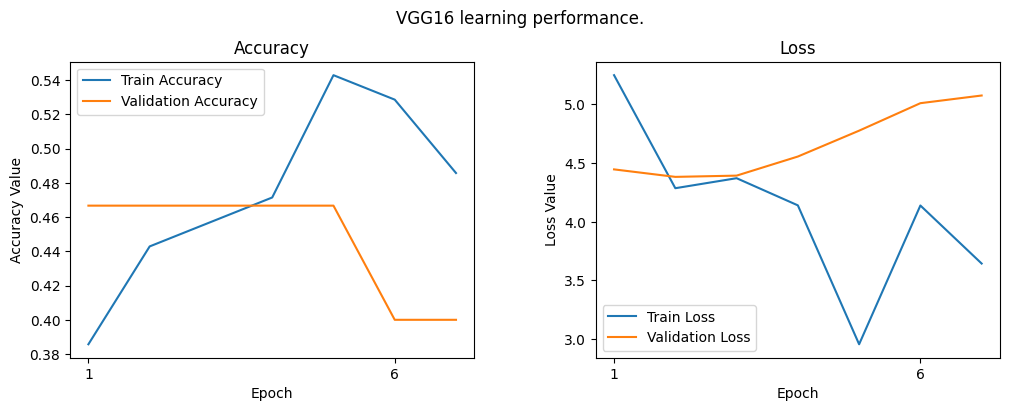

In [120]:
vgg16 = fit_model("VGG16", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

VGG16 performance on the test set:
1/1 [==============================] - 1s 511ms/step
Train accuracy Score------------>
50.000 %
Val accuracy Score--------->
40.000 %
Test accuracy Score--------->
13.333 %
F1 Score--------------->
20.513 %
Cohen Kappa Score------------->
-2.632 %
ROC AUC Score------------->
46.000 %
Recall-------------->
13.333 %
Precision-------------->
44.444 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


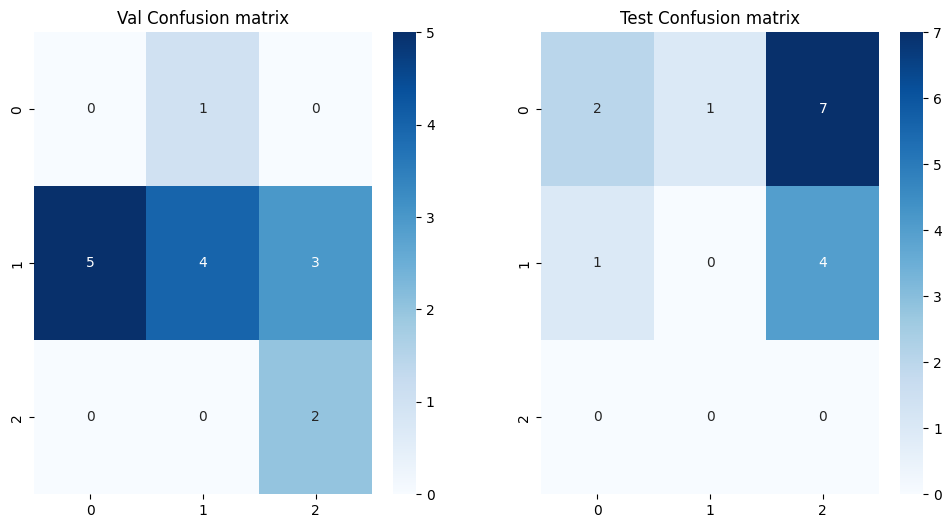

In [121]:
print('VGG16 performance on the test set:')
get_accuracy_metrics(vgg16)

# VGG19 

In [122]:
base_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

80134624/80134624 [==============================] - 8s 0us/step


Model Summary.
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_39 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 3)                 1539      
                                           

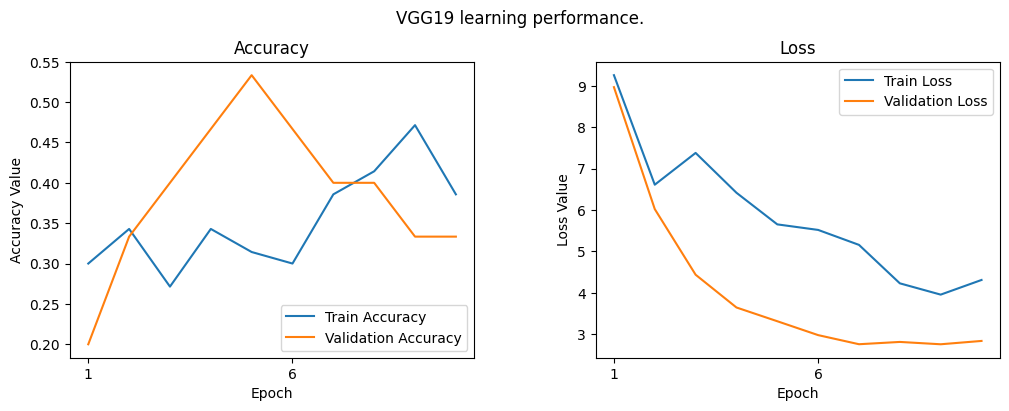

In [123]:
vgg19 = fit_model("VGG19", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

VGG19 performance on the test set:
1/1 [==============================] - 1s 636ms/step
Train accuracy Score------------>
45.714 %
Val accuracy Score--------->
33.333 %
Test accuracy Score--------->
26.667 %
F1 Score--------------->
35.556 %
Cohen Kappa Score------------->
8.333 %
ROC AUC Score------------->
41.000 %
Recall-------------->
26.667 %
Precision-------------->
80.000 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


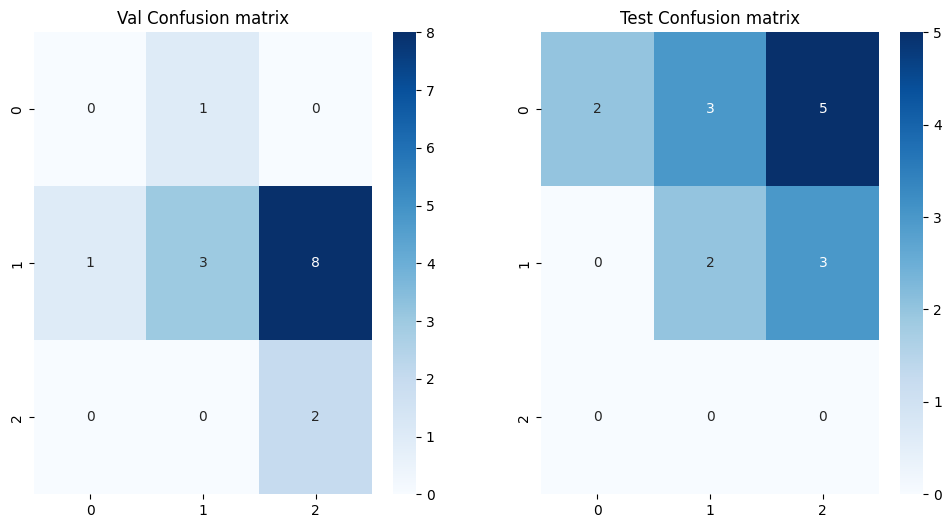

In [124]:
print('VGG19 performance on the test set:')
get_accuracy_metrics(vgg19)

# MobileNet Pretranined

In [125]:
base_model = tf.keras.applications.MobileNet(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

17225924/17225924 [==============================] - 2s 0us/step


Model Summary.
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenet_1.00_160 (Functio  (None, 5, 5, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_40 (Dropout)        (None, 1024)              0         
                                                                 
 dense_18 (Dense)            (None, 3)     

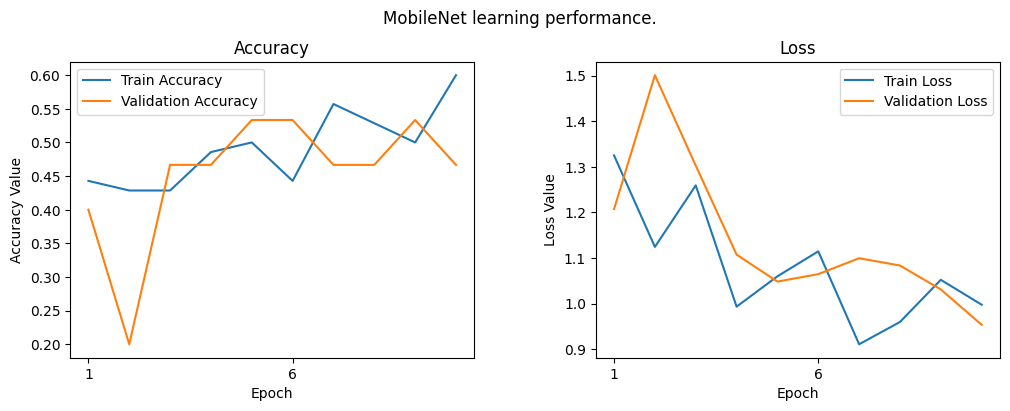

In [126]:
mobilenet = fit_model("MobileNet", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

MobileNet performance on the test set:
1/1 [==============================] - 0s 51ms/step
Train accuracy Score------------>
55.714 %
Val accuracy Score--------->
46.667 %
Test accuracy Score--------->
26.667 %
F1 Score--------------->
37.436 %
Cohen Kappa Score------------->
2.941 %
ROC AUC Score------------->
22.000 %
Recall-------------->
26.667 %
Precision-------------->
73.333 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


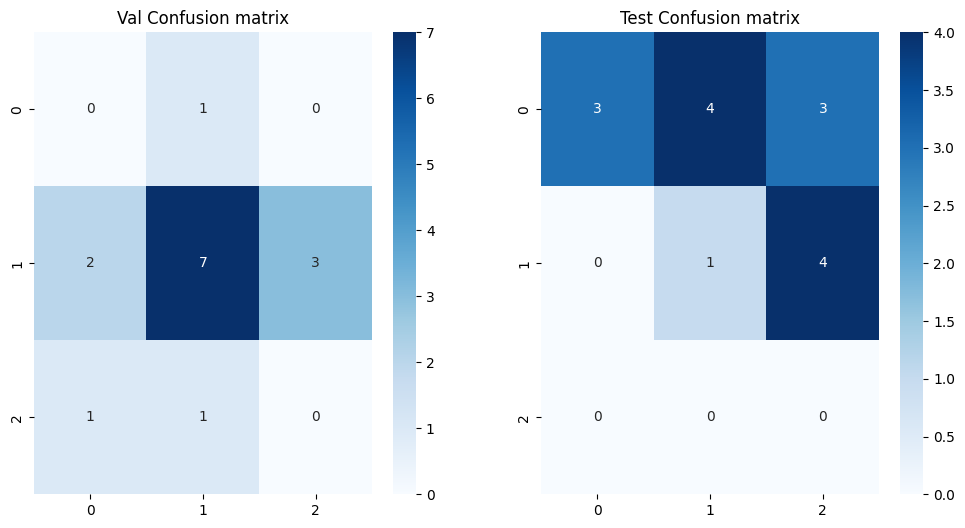

In [127]:
print('MobileNet performance on the test set:')
get_accuracy_metrics(mobilenet)

# MobileNet V2 pre-trained

In [128]:
base_model = tf.keras.applications.MobileNetV2(include_top=False, 
                                               weights='imagenet', 
                                               input_shape=INPUT_SHAPE)

base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


Model Summary.
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_41 (Dropout)        (None, 1280)              0         
                                                                 
 dense_19 (Dense)            (None, 3)     

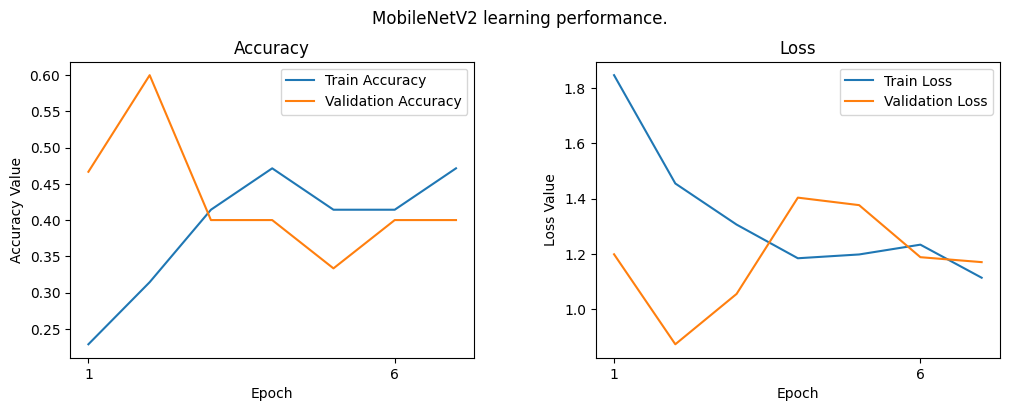

In [129]:
mobilenetv2 = fit_model("MobileNetV2", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))

MobileNetV2 performance on the test set:
1/1 [==============================] - 0s 45ms/step
Train accuracy Score------------>
50.000 %
Val accuracy Score--------->
40.000 %
Test accuracy Score--------->
6.667 %
F1 Score--------------->
6.061 %
Cohen Kappa Score------------->
-13.514 %
ROC AUC Score------------->
50.000 %
Recall-------------->
6.667 %
Precision-------------->
5.556 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


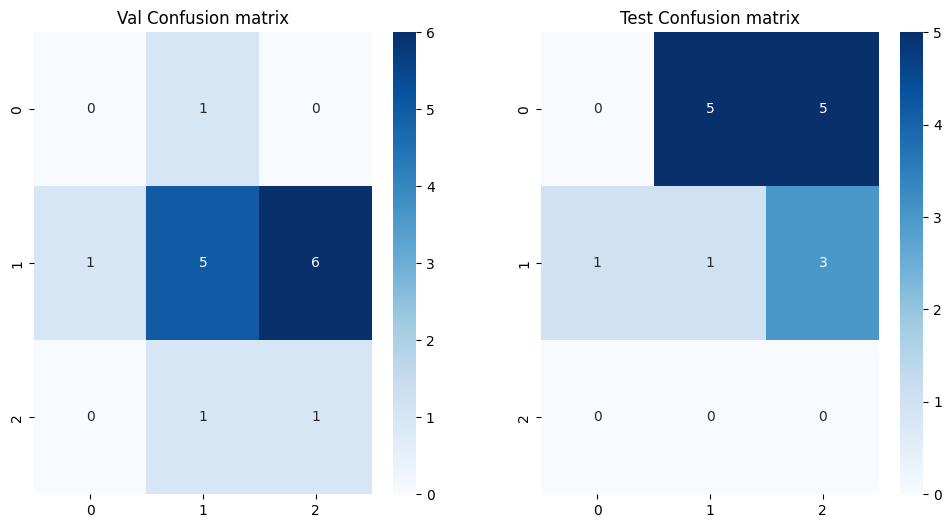

In [130]:
print('MobileNetV2 performance on the test set:')
get_accuracy_metrics(mobilenetv2)

# Inception V3

Model Summary.
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_42 (Dropout)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 3)                 6147      
                                           

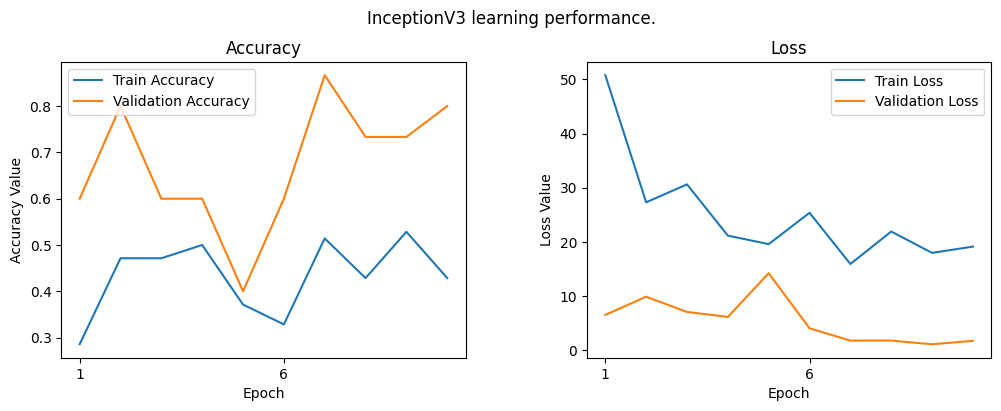

In [131]:
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

incpetionv3 = fit_model("InceptionV3", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


InceptionV3 performance on the test set:
1/1 [==============================] - 0s 83ms/step
Train accuracy Score------------>
61.429 %
Val accuracy Score--------->
80.000 %
Test accuracy Score--------->
26.667 %
F1 Score--------------->
25.455 %
Cohen Kappa Score------------->
0.000 %
ROC AUC Score------------->
37.000 %
Recall-------------->
26.667 %
Precision-------------->
76.667 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


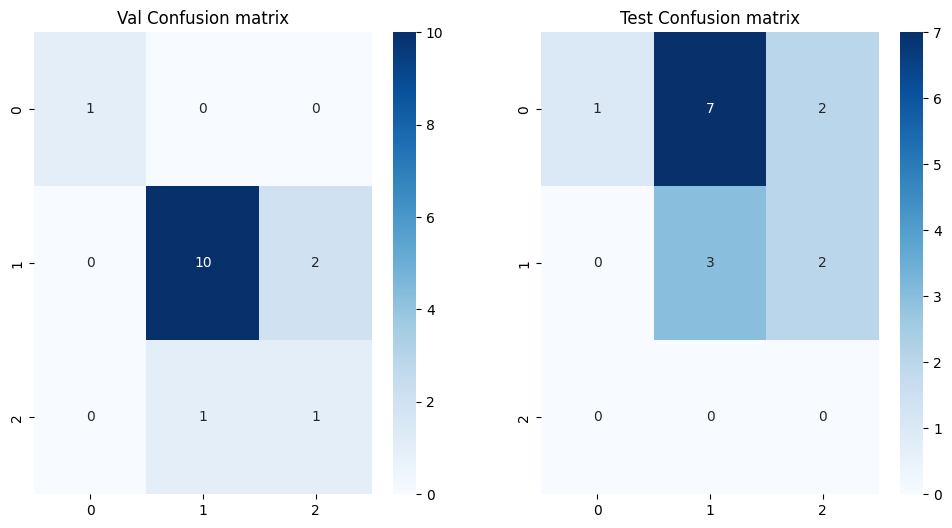

In [132]:
print('InceptionV3 performance on the test set:')
get_accuracy_metrics(incpetionv3)

# DenseNet 121

Model Summary.
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 5, 5, 1024)        7037504   
                                                                 
 global_average_pooling2d_8   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_43 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 3)                 3075      
                                           

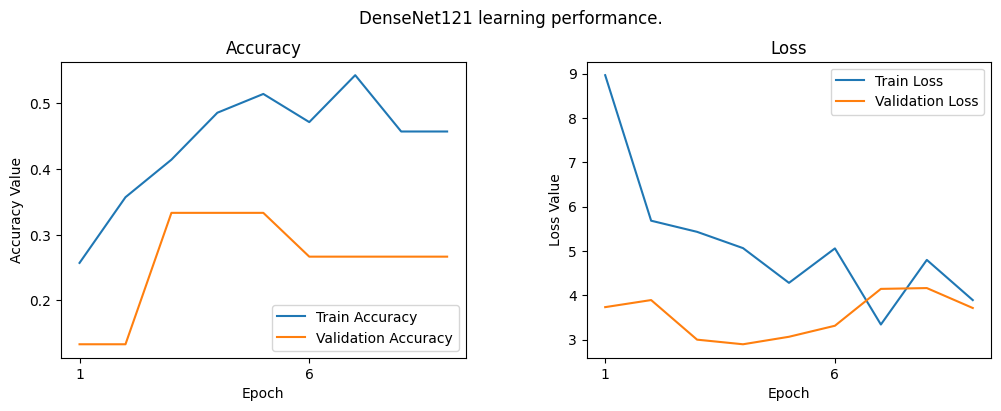

In [133]:
base_model = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

densenet121 = fit_model("DenseNet121", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


DenseNet121 performance on the test set:
1/1 [==============================] - 0s 163ms/step
Train accuracy Score------------>
55.714 %
Val accuracy Score--------->
26.667 %
Test accuracy Score--------->
26.667 %
F1 Score--------------->
38.889 %
Cohen Kappa Score------------->
13.158 %
ROC AUC Score------------->
51.000 %
Recall-------------->
26.667 %
Precision-------------->
88.889 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


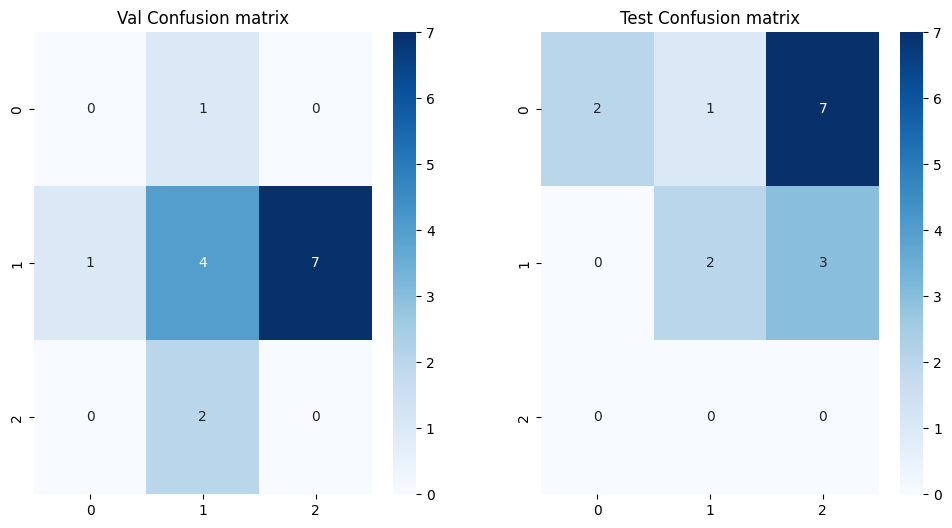

In [134]:
print('DenseNet121 performance on the test set:')
get_accuracy_metrics(densenet121)

# DenseNet 169

51877672/51877672 [==============================] - 5s 0us/step
Model Summary.
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 5, 5, 1664)        12642880  
                                                                 
 global_average_pooling2d_9   (None, 1664)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_44 (Dropout)        (None, 1664)              0         
                                                                 
 dense_22 (Dense)            (None, 3)      

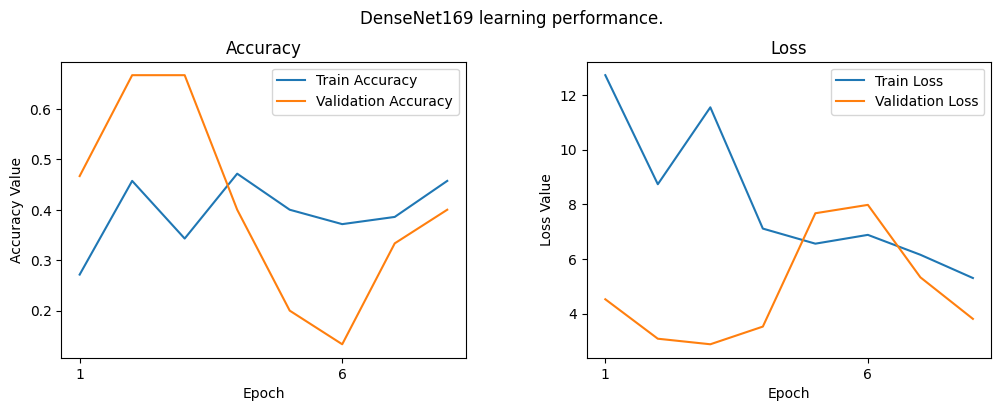

In [135]:
base_model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

densenet169 = fit_model("DenseNet169", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


DenseNet169 performance on the test set:
1/1 [==============================] - 0s 187ms/step
Train accuracy Score------------>
47.143 %
Val accuracy Score--------->
40.000 %
Test accuracy Score--------->
20.000 %
F1 Score--------------->
24.242 %
Cohen Kappa Score------------->
2.703 %
ROC AUC Score------------->
43.000 %
Recall-------------->
20.000 %
Precision-------------->
77.778 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


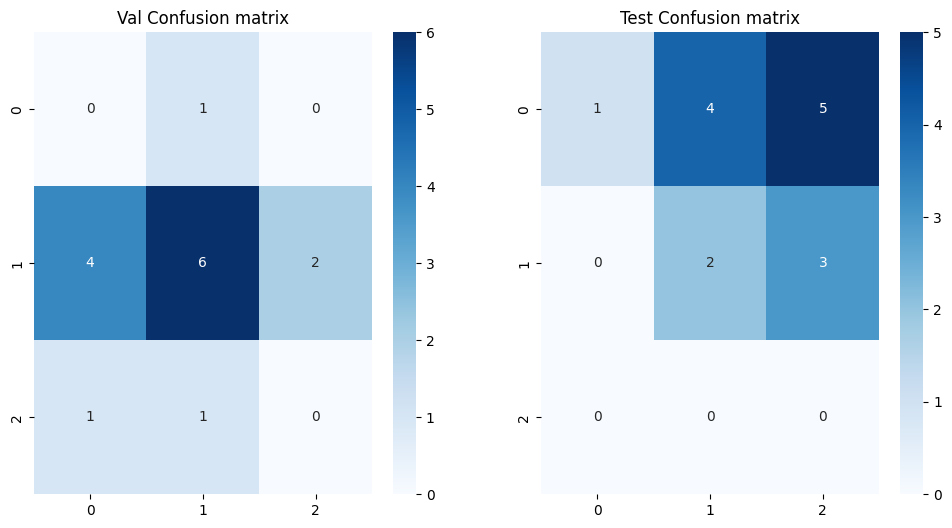

In [136]:

print('DenseNet169 performance on the test set:')
get_accuracy_metrics(densenet169)

# InceptionResNetv2

219055592/219055592 [==============================] - 26s 0us/step
Model Summary.
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 inception_resnet_v2 (Functi  (None, 3, 3, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_10  (None, 1536)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_45 (Dropout)        (None, 1536)              0         
                                         

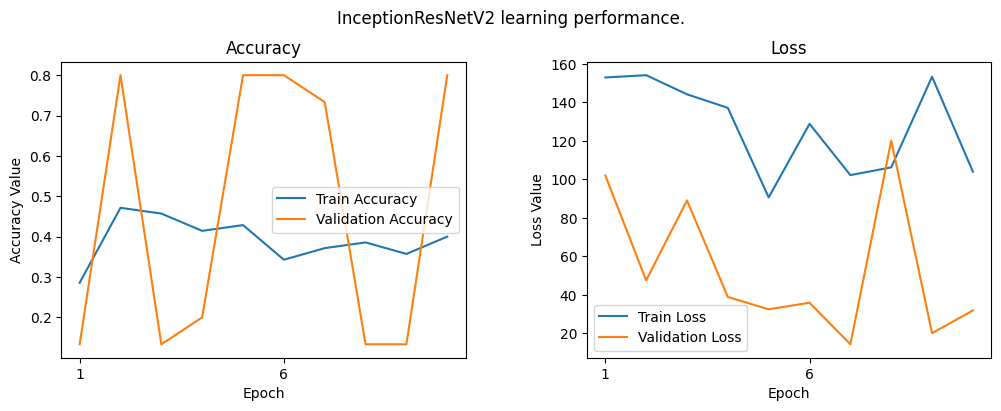

In [137]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

inceptionresnetv2 = fit_model("InceptionResNetV2", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


InceptionResNetV2 performance on the test set:
1/1 [==============================] - 0s 206ms/step
Train accuracy Score------------>
42.857 %
Val accuracy Score--------->
80.000 %
Test accuracy Score--------->
33.333 %
F1 Score--------------->
16.667 %
Cohen Kappa Score------------->
0.000 %
ROC AUC Score------------->
50.000 %
Recall-------------->
33.333 %
Precision-------------->
11.111 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


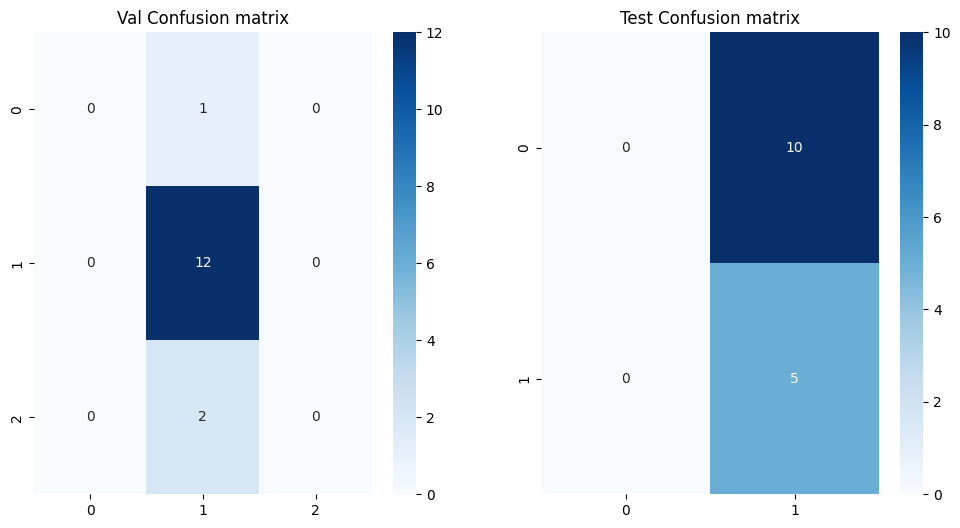

In [138]:
print('InceptionResNetV2 performance on the test set:')
get_accuracy_metrics(inceptionresnetv2)

# ResNet101

171446536/171446536 [==============================] - 19s 0us/step
Model Summary.
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 resnet101 (Functional)      (None, 5, 5, 2048)        42658176  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_46 (Dropout)        (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 3)   

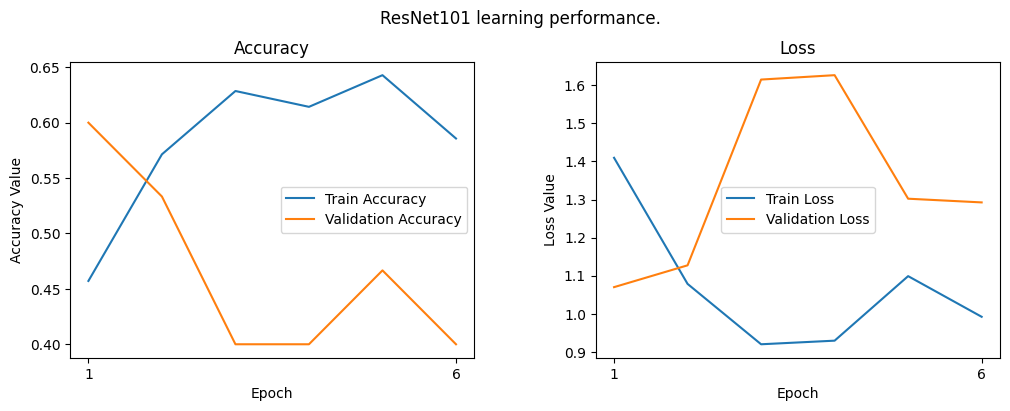

In [139]:
base_model = tf.keras.applications.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=INPUT_SHAPE,
    classes=NUM_CLASSES,
    classifier_activation="softmax",
)

base_model.trainable = False

resnet101 = fit_model("ResNet101", base_model, train_features, train_labels_1hotenc, (val_features, val_labels_1hotenc))


ResNet101 performance on the test set:
1/1 [==============================] - 0s 322ms/step
Train accuracy Score------------>
65.714 %
Val accuracy Score--------->
40.000 %
Test accuracy Score--------->
13.333 %
F1 Score--------------->
15.812 %
Cohen Kappa Score------------->
-21.875 %
ROC AUC Score------------->
56.000 %
Recall-------------->
13.333 %
Precision-------------->
26.984 %


/home/usairim/.local/share/virtualenvs/Project-KXpvUfAX/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


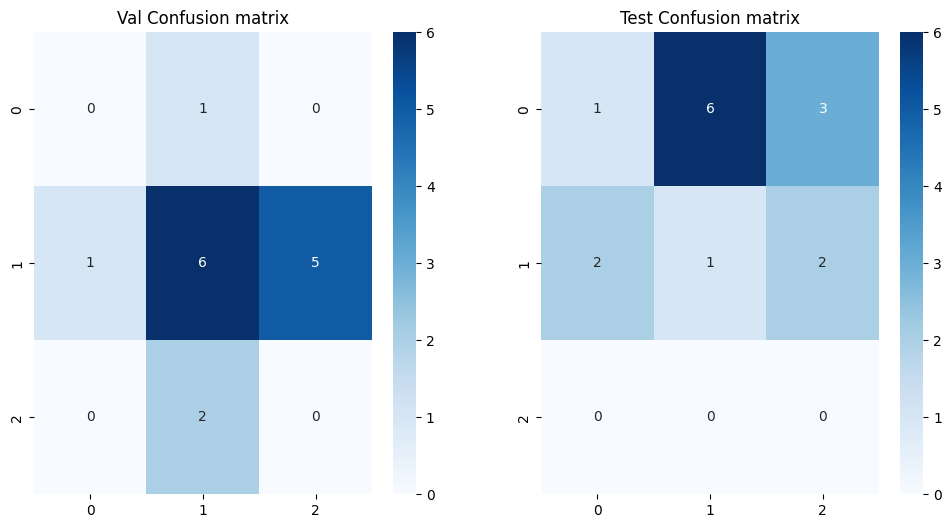

In [140]:
print('ResNet101 performance on the test set:')
get_accuracy_metrics(resnet101)